<a href="https://colab.research.google.com/github/Laaliji/regression_and_classification_labs/blob/main/LRegression_models_comparative_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from math import sqrt, log

# Configuration pour une meilleure visualisation
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12})
sns.set_palette("colorblind")

Dimensions du dataset: (442, 10)
Caractéristiques: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Plage des valeurs cibles: 25.0 à 346.0

Statistiques descriptives des caractéristiques:
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  
count  

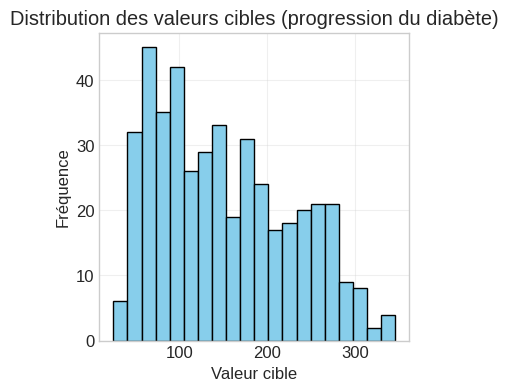

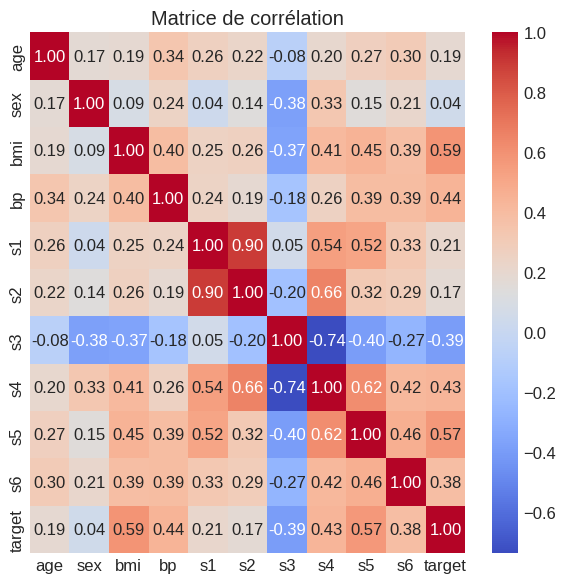

In [33]:
# 1. Chargement des données
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names

print("Dimensions du dataset:", X.shape)
print("Caractéristiques:", feature_names)
print("Plage des valeurs cibles:", y.min(), "à", y.max())
print("\nStatistiques descriptives des caractéristiques:")
df_features = pd.DataFrame(X, columns=feature_names)
print(df_features.describe())

# Visualisation de la distribution des valeurs cibles
plt.figure(figsize=(4, 4))
plt.hist(y, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution des valeurs cibles (progression du diabète)')
plt.xlabel('Valeur cible')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)
plt.show()

# Visualisation des corrélations
plt.figure(figsize=(6, 6))
df_with_target = df_features.copy()
df_with_target['target'] = y
correlation_matrix = df_with_target.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()

In [21]:
# 2. Standardisation des valeurs X et Y
# Note: même si X est déjà standardisé selon l'énoncé, nous le faisons par précaution
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Séparation en ensembles d'entraînement et de test (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

In [22]:
# 3. Définition des métriques d'évaluation
def calculate_metrics(y_true, y_pred, model_name):
    # Calcul des métriques sur les données normalisées
    mse_norm = mean_squared_error(y_true, y_pred)
    rmse_norm = sqrt(mse_norm)
    mae_norm = mean_absolute_error(y_true, y_pred)
    r2_norm = r2_score(y_true, y_pred)

    # Dénormalisation pour calculer les métriques sur les valeurs réelles
    y_true_orig = scaler_y.inverse_transform(y_true.reshape(-1, 1)).ravel()
    y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)

    # Calcul du RMSLE (en évitant les valeurs négatives)
    y_true_pos = np.maximum(y_true_orig, 1e-5)  # Éviter les valeurs négatives ou nulles
    y_pred_pos = np.maximum(y_pred_orig, 1e-5)  # Éviter les valeurs négatives ou nulles
    rmsle = sqrt(mean_squared_error(np.log1p(y_true_pos), np.log1p(y_pred_pos)))

    r2 = r2_score(y_true_orig, y_pred_orig)

    print(f"\n{model_name}:")
    print(f"Sur données normalisées:")
    print(f"MSE normalisé: {mse_norm:.4f}")
    print(f"RMSE normalisé: {rmse_norm:.4f}")
    print(f"MAE normalisé: {mae_norm:.4f}")
    print(f"R² normalisé: {r2_norm:.4f}")

    print(f"\nSur données originales:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSLE: {rmsle:.4f}")
    print(f"R²: {r2:.4f}")

    return {
        'model': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'rmsle': rmsle,
        'r2': r2,
        'mse_norm': mse_norm,
        'rmse_norm': rmse_norm,
        'mae_norm': mae_norm,
        'r2_norm': r2_norm
    }


In [23]:
# 4. Modèles de régression

# Initialisation des modèles
models = {
    'Régression Linéaire': LinearRegression(),
    'Régression Ridge': Ridge(alpha=1.0),
    'Régression Polynomiale (degré 2)': None,  # Sera défini plus tard
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5),
    'KNN (k=10)': KNeighborsRegressor(n_neighbors=10)
}

# Création de caractéristiques polynomiales (degré 2)
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Pour la régression polynomiale
models['Régression Polynomiale (degré 2)'] = LinearRegression()

# Dictionnaire pour stocker les résultats
results = []


=== Évaluation avec la méthode traditionnelle (train/test) ===

Régression Linéaire:
Sur données normalisées:
MSE normalisé: 0.4759
RMSE normalisé: 0.6898
MAE normalisé: 0.5444
R² normalisé: 0.4773

Sur données originales:
MSE: 2821.75
RMSE: 53.12
MAE: 41.92
RMSLE: 0.4124
R²: 0.4773


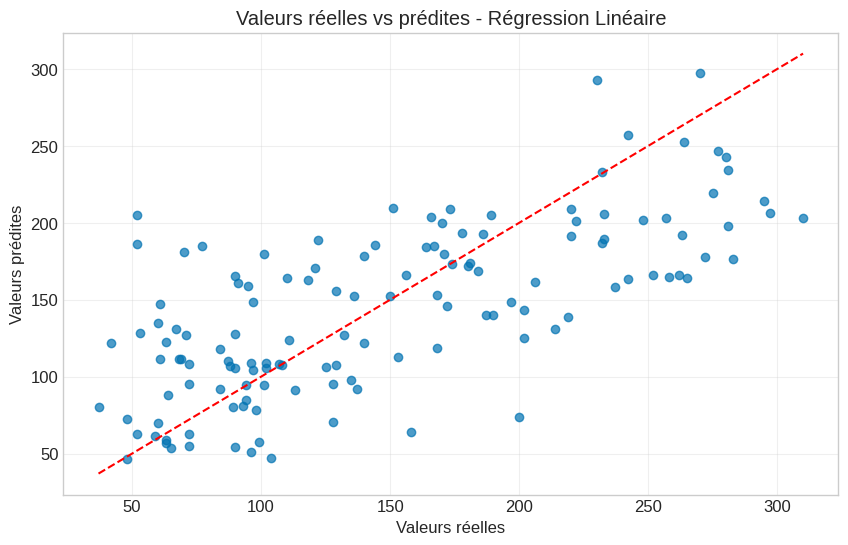


Régression Ridge:
Sur données normalisées:
MSE normalisé: 0.4756
RMSE normalisé: 0.6896
MAE normalisé: 0.5438
R² normalisé: 0.4776

Sur données originales:
MSE: 2820.02
RMSE: 53.10
MAE: 41.88
RMSLE: 0.4100
R²: 0.4776


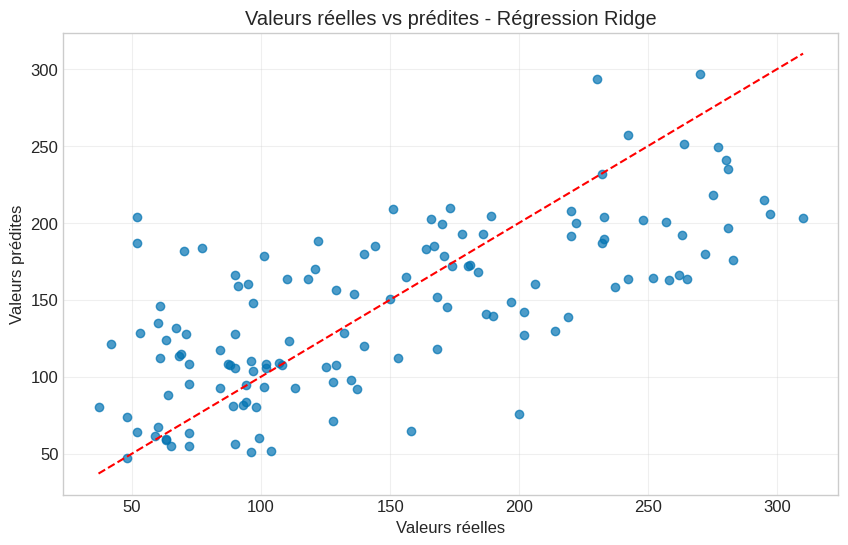


Régression Polynomiale (degré 2):
Sur données normalisées:
MSE normalisé: 0.5344
RMSE normalisé: 0.7310
MAE normalisé: 0.5743
R² normalisé: 0.4130

Sur données originales:
MSE: 3168.93
RMSE: 56.29
MAE: 44.22
RMSLE: 0.4216
R²: 0.4130


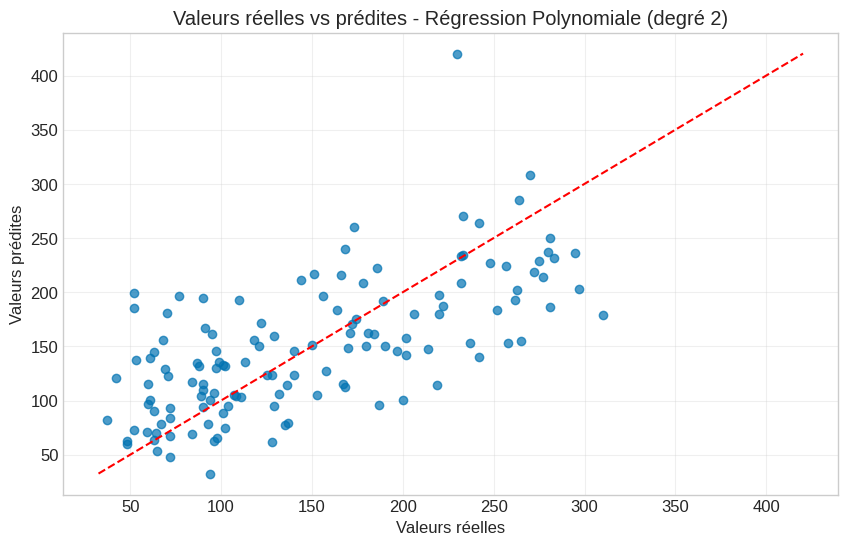


KNN (k=5):
Sur données normalisées:
MSE normalisé: 0.5434
RMSE normalisé: 0.7371
MAE normalisé: 0.5714
R² normalisé: 0.4031

Sur données originales:
MSE: 3222.12
RMSE: 56.76
MAE: 44.00
RMSLE: 0.4284
R²: 0.4031


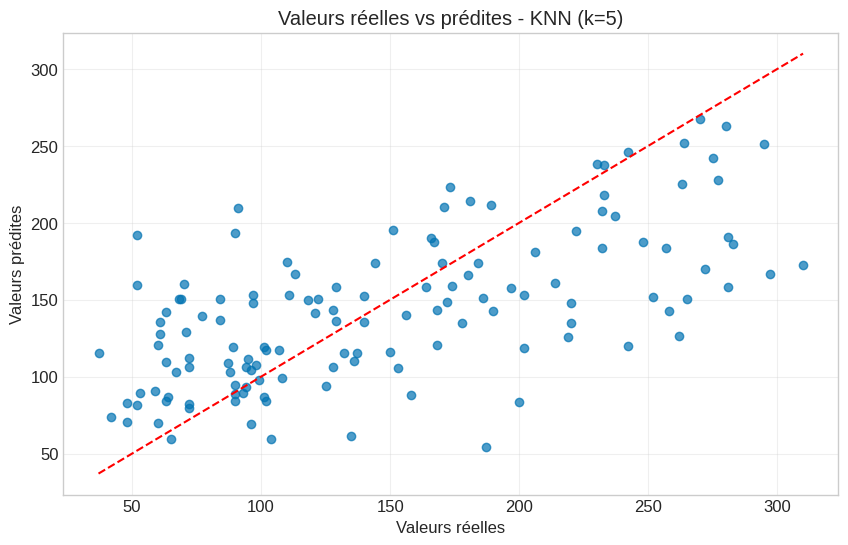


KNN (k=10):
Sur données normalisées:
MSE normalisé: 0.5323
RMSE normalisé: 0.7296
MAE normalisé: 0.5809
R² normalisé: 0.4153

Sur données originales:
MSE: 3156.48
RMSE: 56.18
MAE: 44.73
RMSLE: 0.4228
R²: 0.4153


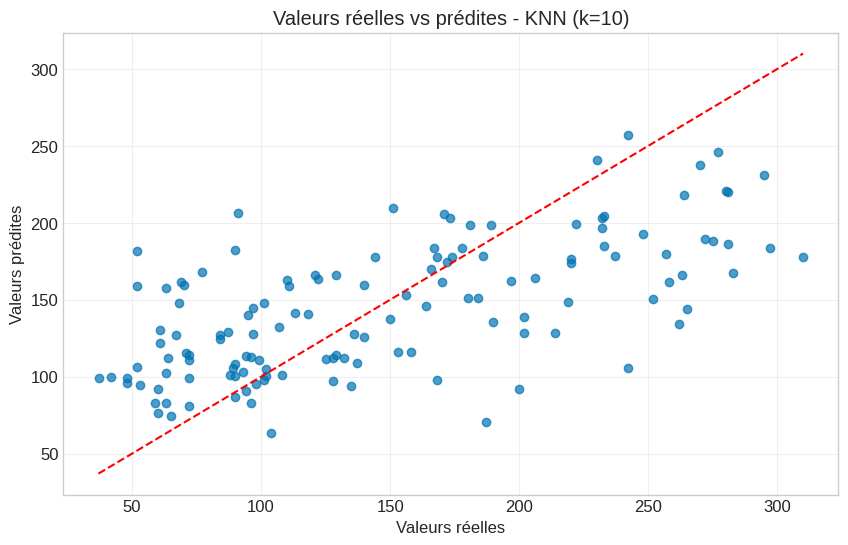

In [24]:
# 5. Entraînement et évaluation (stratégie traditionnelle)
print("\n=== Évaluation avec la méthode traditionnelle (train/test) ===")

for name, model in models.items():
    if 'Polynomiale' in name:
        model.fit(X_poly_train, y_train)
        y_pred = model.predict(X_poly_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    result = calculate_metrics(y_test, y_pred, name)
    results.append(result)

    # Visualisation des prédictions vs valeurs réelles
    plt.figure(figsize=(10, 6))

    # Inverse la normalisation pour l'affichage
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    plt.scatter(y_test_orig, y_pred_orig, alpha=0.7)

    # Ligne parfaite de prédiction
    min_val = min(y_test_orig.min(), y_pred_orig.min())
    max_val = max(y_test_orig.max(), y_pred_orig.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title(f'Valeurs réelles vs prédites - {name}')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Valeurs prédites')
    plt.grid(True, alpha=0.3)
    plt.show()

In [25]:
# 6. Évaluation avec validation croisée
print("\n=== Évaluation avec validation croisée (5-fold) ===")

cv_results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    if 'Polynomiale' in name:
        # Pour la régression polynomiale, nous devons traiter différemment
        mse_scores = []
        mae_scores = []
        rmsle_scores = []
        r2_scores = []
        mse_norm_scores = []
        r2_norm_scores = []

        for train_idx, test_idx in kf.split(X_scaled):
            X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
            y_train_cv, y_test_cv = y_scaled[train_idx], y_scaled[test_idx]

            # Transformation polynomiale
            X_train_poly_cv = poly.fit_transform(X_train_cv)
            X_test_poly_cv = poly.transform(X_test_cv)

            model.fit(X_train_poly_cv, y_train_cv)
            y_pred_cv = model.predict(X_test_poly_cv)

            # Métriques normalisées
            mse_norm = mean_squared_error(y_test_cv, y_pred_cv)
            r2_norm = r2_score(y_test_cv, y_pred_cv)
            mse_norm_scores.append(mse_norm)
            r2_norm_scores.append(r2_norm)

            # Calcul des métriques sur données originales
            y_test_orig = scaler_y.inverse_transform(y_test_cv.reshape(-1, 1)).ravel()
            y_pred_orig = scaler_y.inverse_transform(y_pred_cv.reshape(-1, 1)).ravel()

            mse = mean_squared_error(y_test_orig, y_pred_orig)
            mae = mean_absolute_error(y_test_orig, y_pred_orig)

            # Calcul du RMSLE
            y_test_pos = np.maximum(y_test_orig, 1e-5)
            y_pred_pos = np.maximum(y_pred_orig, 1e-5)
            rmsle = sqrt(mean_squared_error(np.log1p(y_test_pos), np.log1p(y_pred_pos)))

            r2 = r2_score(y_test_orig, y_pred_orig)

            mse_scores.append(mse)
            mae_scores.append(mae)
            rmsle_scores.append(rmsle)
            r2_scores.append(r2)

        print(f"\n{name} (CV):")
        print(f"Sur données normalisées:")
        print(f"MSE normalisé moyen: {np.mean(mse_norm_scores):.4f} (±{np.std(mse_norm_scores):.4f})")
        print(f"R² normalisé moyen: {np.mean(r2_norm_scores):.4f} (±{np.std(r2_norm_scores):.4f})")

        print(f"\nSur données originales:")
        print(f"MSE moyen: {np.mean(mse_scores):.2f} (±{np.std(mse_scores):.2f})")
        print(f"RMSE moyen: {np.mean([sqrt(x) for x in mse_scores]):.2f}")
        print(f"MAE moyen: {np.mean(mae_scores):.2f} (±{np.std(mae_scores):.2f})")
        print(f"RMSLE moyen: {np.mean(rmsle_scores):.4f} (±{np.std(rmsle_scores):.4f})")
        print(f"R² moyen: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")

        cv_result = {
            'model': name + ' (CV)',
            'mse': np.mean(mse_scores),
            'rmse': np.mean([sqrt(x) for x in mse_scores]),
            'mae': np.mean(mae_scores),
            'rmsle': np.mean(rmsle_scores),
            'r2': np.mean(r2_scores),
            'mse_norm': np.mean(mse_norm_scores),
            'rmse_norm': np.mean([sqrt(x) for x in mse_norm_scores]),
            'mae_norm': None,  # Non calculé pour simplifier
            'r2_norm': np.mean(r2_norm_scores)
        }
        cv_results.append(cv_result)

    else:
        # Pour les autres modèles
        mse_scores = []
        mae_scores = []
        rmsle_scores = []
        r2_scores = []
        mse_norm_scores = []
        r2_norm_scores = []

        for train_idx, test_idx in kf.split(X_scaled):
            X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
            y_train_cv, y_test_cv = y_scaled[train_idx], y_scaled[test_idx]

            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_test_cv)

            # Métriques normalisées
            mse_norm = mean_squared_error(y_test_cv, y_pred_cv)
            r2_norm = r2_score(y_test_cv, y_pred_cv)
            mse_norm_scores.append(mse_norm)
            r2_norm_scores.append(r2_norm)

            # Calcul des métriques sur données originales
            y_test_orig = scaler_y.inverse_transform(y_test_cv.reshape(-1, 1)).ravel()
            y_pred_orig = scaler_y.inverse_transform(y_pred_cv.reshape(-1, 1)).ravel()

            mse = mean_squared_error(y_test_orig, y_pred_orig)
            mae = mean_absolute_error(y_test_orig, y_pred_orig)

            # Calcul du RMSLE
            y_test_pos = np.maximum(y_test_orig, 1e-5)
            y_pred_pos = np.maximum(y_pred_orig, 1e-5)
            rmsle = sqrt(mean_squared_error(np.log1p(y_test_pos), np.log1p(y_pred_pos)))

            r2 = r2_score(y_test_orig, y_pred_orig)

            mse_scores.append(mse)
            mae_scores.append(mae)
            rmsle_scores.append(rmsle)
            r2_scores.append(r2)

        print(f"\n{name} (CV):")
        print(f"Sur données normalisées:")
        print(f"MSE normalisé moyen: {np.mean(mse_norm_scores):.4f} (±{np.std(mse_norm_scores):.4f})")
        print(f"R² normalisé moyen: {np.mean(r2_norm_scores):.4f} (±{np.std(r2_norm_scores):.4f})")

        print(f"\nSur données originales:")
        print(f"MSE moyen: {np.mean(mse_scores):.2f} (±{np.std(mse_scores):.2f})")
        print(f"RMSE moyen: {np.mean([sqrt(x) for x in mse_scores]):.2f}")
        print(f"MAE moyen: {np.mean(mae_scores):.2f} (±{np.std(mae_scores):.2f})")
        print(f"RMSLE moyen: {np.mean(rmsle_scores):.4f} (±{np.std(rmsle_scores):.4f})")
        print(f"R² moyen: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")

        cv_result = {
            'model': name + ' (CV)',
            'mse': np.mean(mse_scores),
            'rmse': np.mean([sqrt(x) for x in mse_scores]),
            'mae': np.mean(mae_scores),
            'rmsle': np.mean(rmsle_scores),
            'r2': np.mean(r2_scores),
            'mse_norm': np.mean(mse_norm_scores),
            'rmse_norm': np.mean([sqrt(x) for x in mse_norm_scores]),
            'mae_norm': None,  # Non calculé pour simplifier
            'r2_norm': np.mean(r2_norm_scores)
        }
        cv_results.append(cv_result)


=== Évaluation avec validation croisée (5-fold) ===

Régression Linéaire (CV):
Sur données normalisées:
MSE normalisé moyen: 0.5085 (±0.0491)
R² normalisé moyen: 0.4785 (±0.0850)

Sur données originales:
MSE moyen: 3015.38 (±291.24)
RMSE moyen: 54.85
MAE moyen: 44.27 (±2.61)
RMSLE moyen: 0.4222 (±0.0318)
R² moyen: 0.4785 (±0.0850)

Régression Ridge (CV):
Sur données normalisées:
MSE normalisé moyen: 0.5080 (±0.0477)
R² normalisé moyen: 0.4791 (±0.0834)

Sur données originales:
MSE moyen: 3012.66 (±282.69)
RMSE moyen: 54.83
MAE moyen: 44.24 (±2.53)
RMSLE moyen: 0.4206 (±0.0315)
R² moyen: 0.4791 (±0.0834)

Régression Polynomiale (degré 2) (CV):
Sur données normalisées:
MSE normalisé moyen: 0.6226 (±0.0923)
R² normalisé moyen: 0.3658 (±0.1061)

Sur données originales:
MSE moyen: 3692.14 (±547.62)
RMSE moyen: 60.60
MAE moyen: 48.32 (±3.85)
RMSLE moyen: 0.4630 (±0.0485)
R² moyen: 0.3658 (±0.1061)

KNN (k=5) (CV):
Sur données normalisées:
MSE normalisé moyen: 0.6013 (±0.0615)
R² normalisé m


=== Récapitulatif des performances (données originales) ===
                                   model          mse       rmse        mae  \
0                    Régression Linéaire  2821.750981  53.120156  41.919378   
1                       Régression Ridge  2820.024357  53.103902  41.878786   
2       Régression Polynomiale (degré 2)  3168.930444  56.293254  44.221396   
3                              KNN (k=5)  3222.117895  56.763702  44.003008   
4                             KNN (k=10)  3156.481504  56.182573  44.729323   
5               Régression Linéaire (CV)  3015.381694  54.848941  44.269746   
6                  Régression Ridge (CV)  3012.661077  54.827773  44.244182   
7  Régression Polynomiale (degré 2) (CV)  3692.135820  60.597328  48.322955   
8                         KNN (k=5) (CV)  3565.413506  59.630915  46.738733   
9                        KNN (k=10) (CV)  3394.226227  58.228986  46.608981   

      rmsle        r2  
0  0.412419  0.477290  
1  0.409970  0.477610

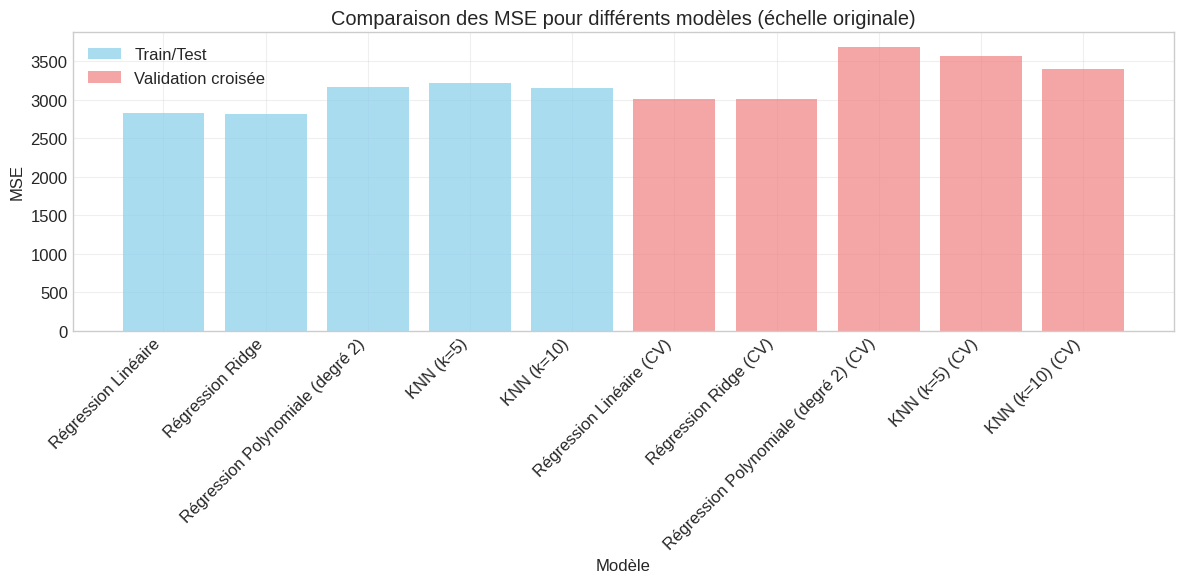

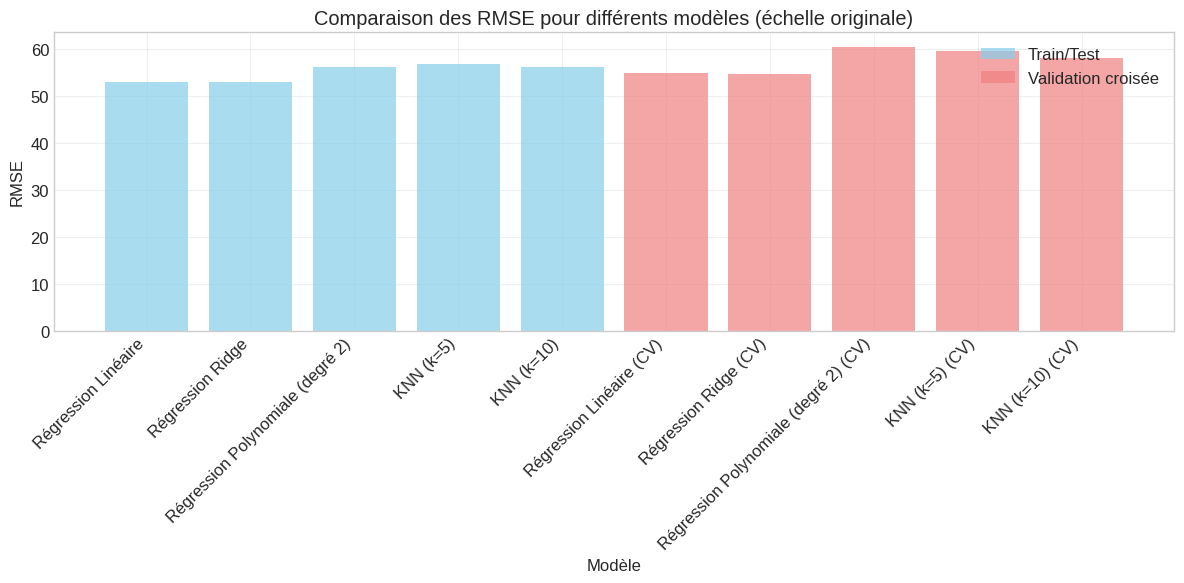

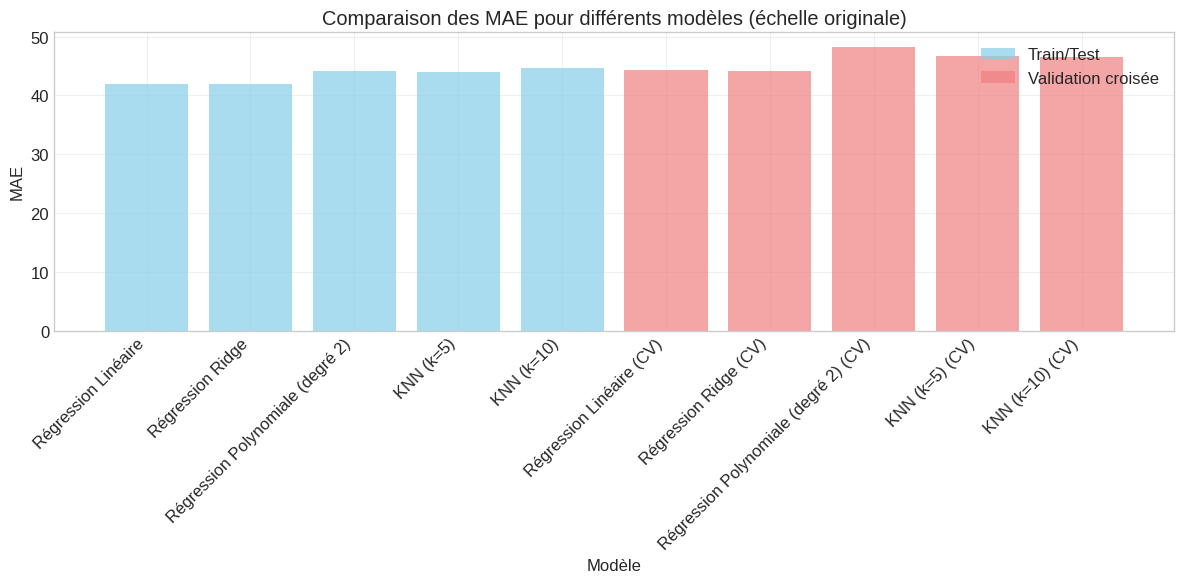

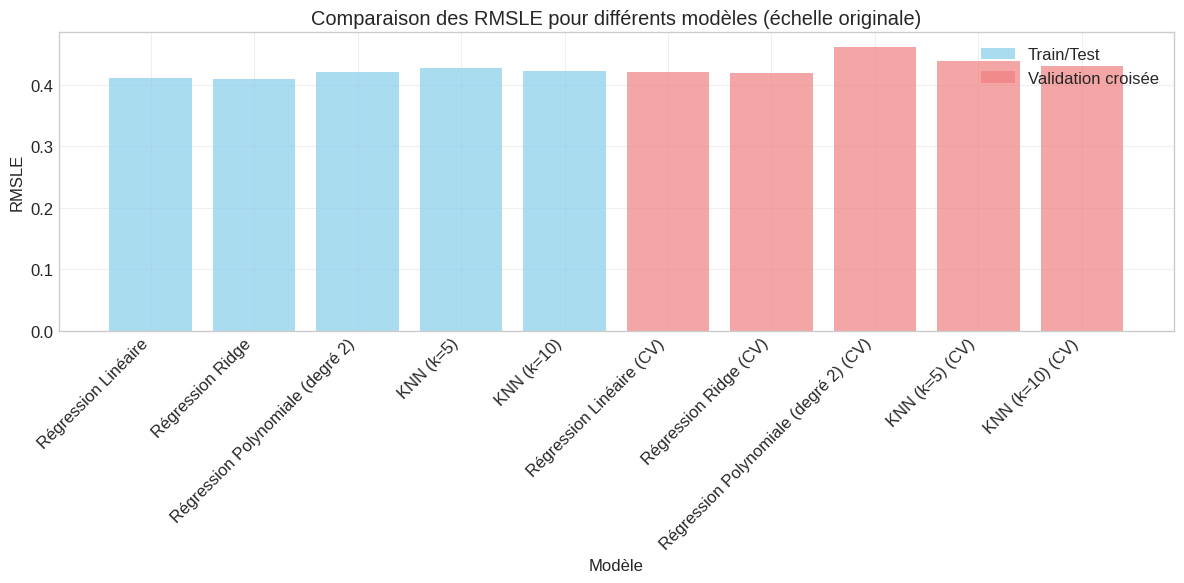

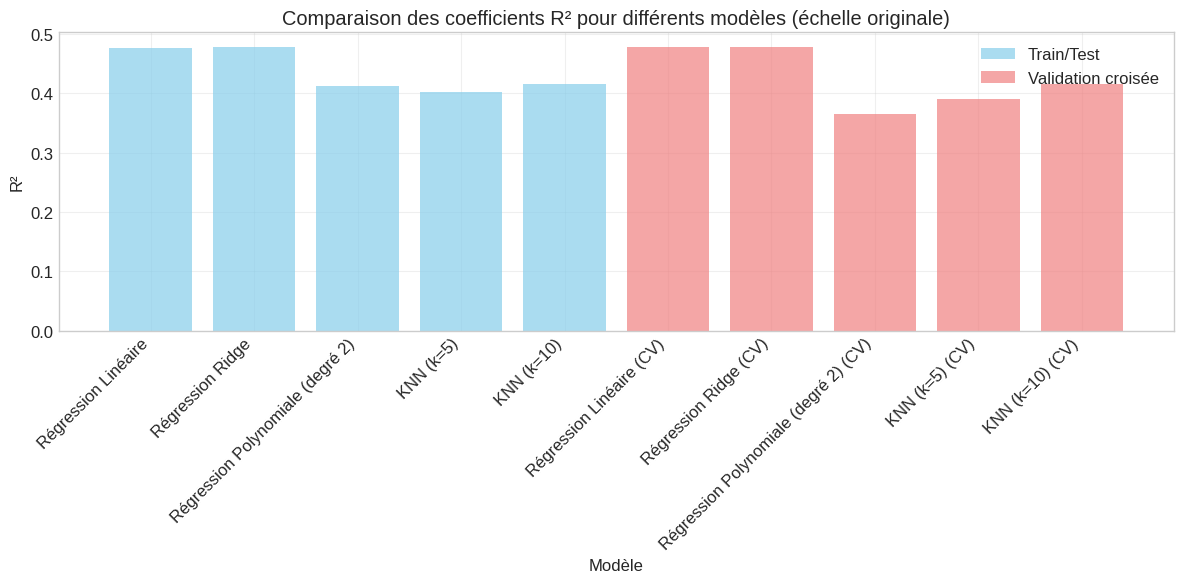

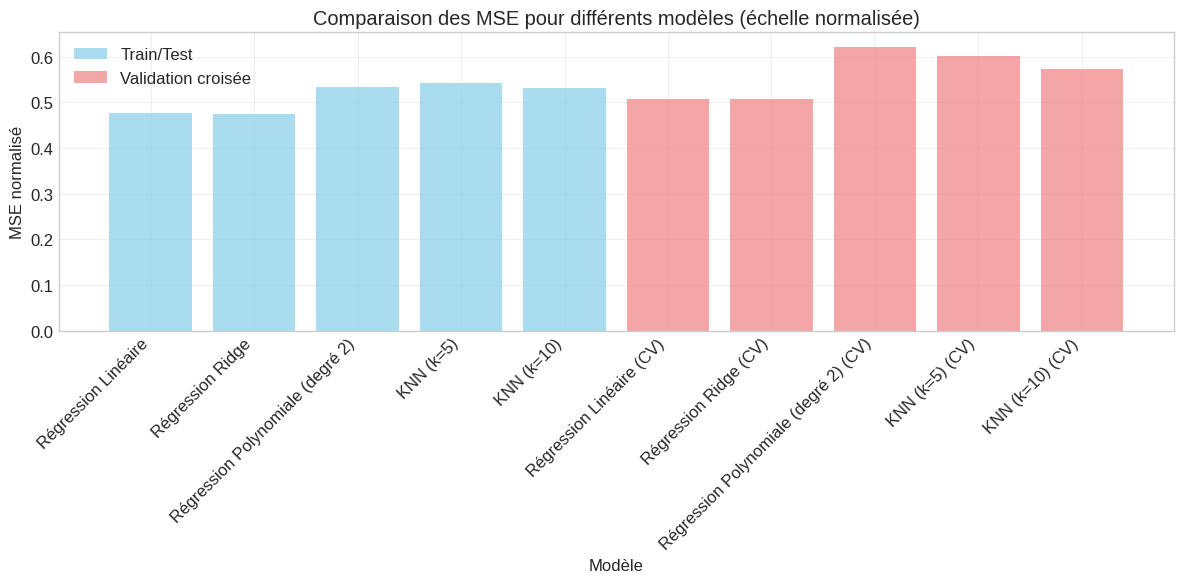

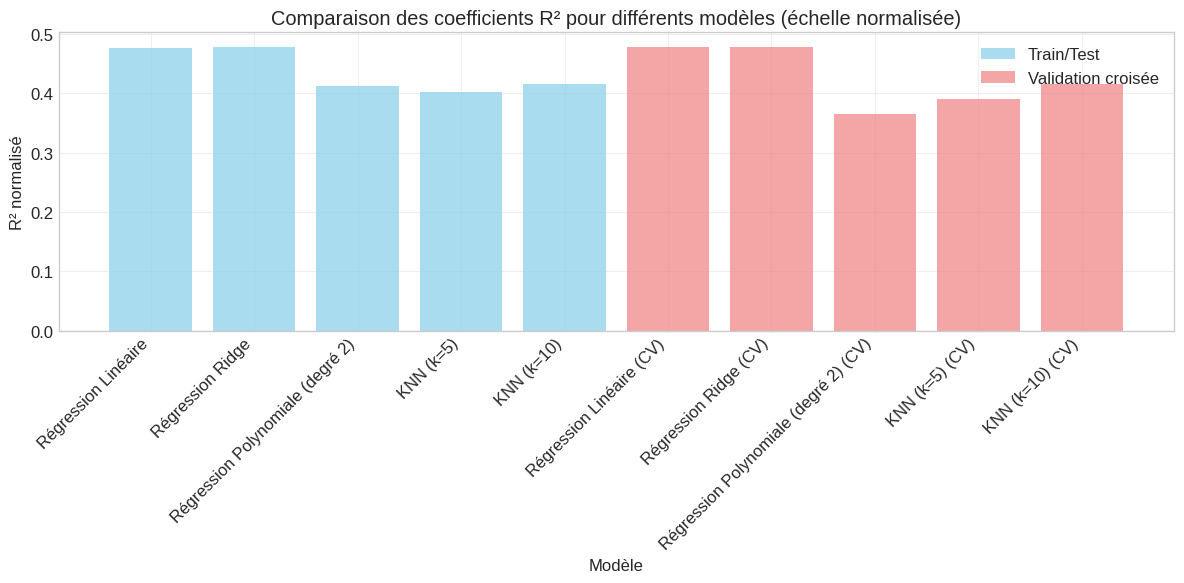

In [26]:
# 7. Comparaison des modèles
all_results = results + cv_results

# Création d'un DataFrame pour faciliter la comparaison
df_results = pd.DataFrame(all_results)
print("\n=== Récapitulatif des performances (données originales) ===")
print(df_results[['model', 'mse', 'rmse', 'mae', 'rmsle', 'r2']])

print("\n=== Récapitulatif des performances (données normalisées) ===")
print(df_results[['model', 'mse_norm', 'r2_norm']])

# Visualisation des performances (échelle originale)
metrics = ['mse', 'rmse', 'mae', 'rmsle']
for metric in metrics:
    plt.figure(figsize=(12, 6))

    # Séparation des modèles traditionnels et CV
    df_trad = df_results[~df_results['model'].str.contains('CV')]
    df_cv = df_results[df_results['model'].str.contains('CV')]

    # Barres pour les modèles traditionnels
    plt.bar(df_trad['model'], df_trad[metric], alpha=0.7, color='skyblue', label='Train/Test')

    # Barres pour les modèles CV
    if not df_cv.empty:
        plt.bar(df_cv['model'], df_cv[metric], alpha=0.7, color='lightcoral', label='Validation croisée')

    plt.title(f'Comparaison des {metric.upper()} pour différents modèles (échelle originale)')
    plt.xlabel('Modèle')
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualisation du coefficient R² (échelle originale)
plt.figure(figsize=(12, 6))
# Barres pour les modèles traditionnels
plt.bar(df_trad['model'], df_trad['r2'], alpha=0.7, color='skyblue', label='Train/Test')

# Barres pour les modèles CV
if not df_cv.empty:
    plt.bar(df_cv['model'], df_cv['r2'], alpha=0.7, color='lightcoral', label='Validation croisée')

plt.title('Comparaison des coefficients R² pour différents modèles (échelle originale)')
plt.xlabel('Modèle')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualisation des performances (échelle normalisée)
plt.figure(figsize=(12, 6))
plt.bar(df_trad['model'], df_trad['mse_norm'], alpha=0.7, color='skyblue', label='Train/Test')
plt.bar(df_cv['model'], df_cv['mse_norm'], alpha=0.7, color='lightcoral', label='Validation croisée')
plt.title('Comparaison des MSE pour différents modèles (échelle normalisée)')
plt.xlabel('Modèle')
plt.ylabel('MSE normalisé')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(df_trad['model'], df_trad['r2_norm'], alpha=0.7, color='skyblue', label='Train/Test')
plt.bar(df_cv['model'], df_cv['r2_norm'], alpha=0.7, color='lightcoral', label='Validation croisée')
plt.title('Comparaison des coefficients R² pour différents modèles (échelle normalisée)')
plt.xlabel('Modèle')
plt.ylabel('R² normalisé')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


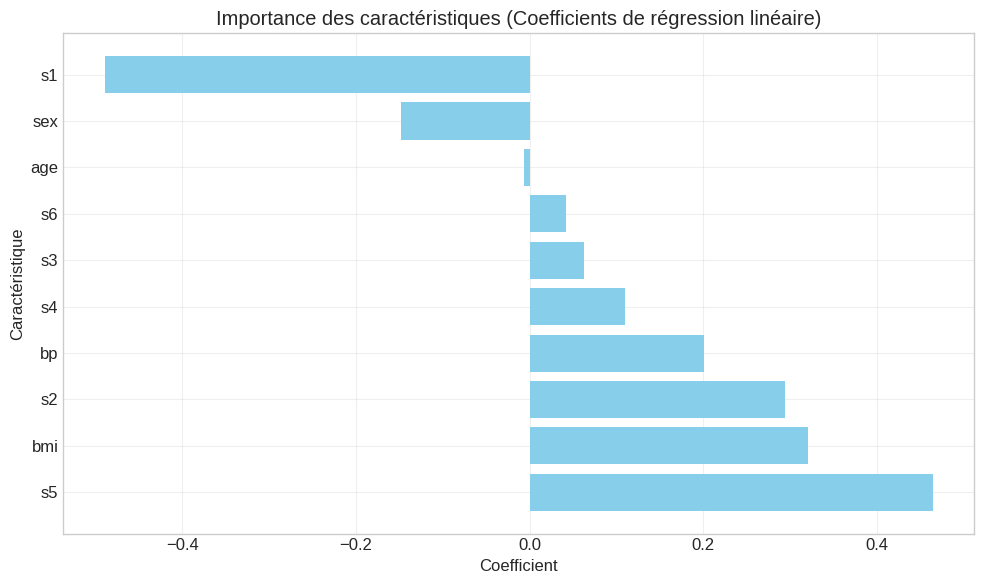

In [27]:
# 8. Analyse de l'importance des caractéristiques pour la régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_scaled)

# Coefficients de la régression linéaire
coef = pd.DataFrame({
    'Caractéristique': feature_names,
    'Coefficient': lin_reg.coef_
})
coef = coef.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef['Caractéristique'], coef['Coefficient'], color='skyblue')
plt.title('Importance des caractéristiques (Coefficients de régression linéaire)')
plt.xlabel('Coefficient')
plt.ylabel('Caractéristique')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# 9. Apprentissage sur données non normalisées pour comparaison
print("\n=== Comparaison avec apprentissage sur données non normalisées ===")

# Séparation en ensembles d'entraînement et de test (mêmes indices)
X_original = diabetes.data
y_original = diabetes.target

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42
)

# Entraînement d'un modèle de régression linéaire sur données non normalisées
lin_reg_orig = LinearRegression()
lin_reg_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = lin_reg_orig.predict(X_test_orig)

mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_orig = sqrt(mse_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
r2_orig = r2_score(y_test_orig, y_pred_orig)

print("Régression Linéaire (sans normalisation):")
print(f"MSE: {mse_orig:.2f}")
print(f"RMSE: {rmse_orig:.2f}")
print(f"MAE: {mae_orig:.2f}")
print(f"R²: {r2_orig:.4f}")

# Comparaison des performances avec et sans normalisation
print("\n=== Différence avec/sans normalisation ===")
linear_norm_result = next(res for res in results if res['model'] == 'Régression Linéaire')
print(f"R² avec normalisation: {linear_norm_result['r2']:.4f}")
print(f"R² sans normalisation: {r2_orig:.4f}")
print(f"Différence de R²: {linear_norm_result['r2'] - r2_orig:.4f}")


=== Comparaison avec apprentissage sur données non normalisées ===
Régression Linéaire (sans normalisation):
MSE: 2821.75
RMSE: 53.12
MAE: 41.92
R²: 0.4773

=== Différence avec/sans normalisation ===
R² avec normalisation: 0.4773
R² sans normalisation: 0.4773
Différence de R²: 0.0000


In [29]:
# 10. Conclusions de l'analyse

print("\n=== Analyse des résultats ===")
print("1. Modèles avec sous-apprentissage (sous-fitting):")
print("   - Les modèles avec des performances faibles à la fois sur l'ensemble d'entraînement et de test")
low_r2_models = df_results[df_results['r2'] < df_results['r2'].median()]['model'].tolist()
print(f"   - Modèles identifiés: {', '.join(low_r2_models)}")

print("\n2. Modèles avec sur-apprentissage (sur-fitting):")
print("   - Les modèles qui ont une grande différence entre l'entraînement et la validation croisée")
# Approche simplifiée : comparer les modèles standard avec leur version CV
overfit_models = []
for model_name in [m for m in df_trad['model'] if m != 'Régression Polynomiale (degré 2)']:
    model_r2 = df_trad[df_trad['model'] == model_name]['r2'].values[0]
    model_cv_name = model_name + ' (CV)'
    model_cv_r2 = df_cv[df_cv['model'] == model_cv_name]['r2'].values[0]

    if model_r2 - model_cv_r2 > 0.05:  # Seuil arbitraire de 0.05 pour la différence
        overfit_models.append(model_name)

if overfit_models:
    print(f"   - Modèles identifiés: {', '.join(overfit_models)}")
else:
    print("   - Aucun modèle ne montre de signes clairs de sur-apprentissage avec le seuil défini")

print("\n3. Modèle le plus pertinent:")
best_model = df_results.loc[df_results['r2'].idxmax()]
print(f"   - Le modèle le plus pertinent selon R² est: {best_model['model']} avec R² = {best_model['r2']:.4f}")

lowest_rmse_model = df_results.loc[df_results['rmse'].idxmin()]
print(f"   - Le modèle avec le RMSE le plus faible est: {lowest_rmse_model['model']} avec RMSE = {lowest_rmse_model['rmse']:.2f}")

print("\n4. Impact de la normalisation:")
print(f"   - La différence de R² pour la régression linéaire: {linear_norm_result['r2'] - r2_orig:.4f}")
if linear_norm_result['r2'] > r2_orig:
    print("   - La normalisation a amélioré les performances du modèle")
else:
    print("   - La normalisation n'a pas amélioré les performances du modèle dans ce cas")


=== Analyse des résultats ===
1. Modèles avec sous-apprentissage (sous-fitting):
   - Les modèles avec des performances faibles à la fois sur l'ensemble d'entraînement et de test
   - Modèles identifiés: Régression Polynomiale (degré 2), KNN (k=5), KNN (k=10), Régression Polynomiale (degré 2) (CV), KNN (k=5) (CV)

2. Modèles avec sur-apprentissage (sur-fitting):
   - Les modèles qui ont une grande différence entre l'entraînement et la validation croisée
   - Aucun modèle ne montre de signes clairs de sur-apprentissage avec le seuil défini

3. Modèle le plus pertinent:
   - Le modèle le plus pertinent selon R² est: Régression Ridge (CV) avec R² = 0.4791
   - Le modèle avec le RMSE le plus faible est: Régression Ridge avec RMSE = 53.10

4. Impact de la normalisation:
   - La différence de R² pour la régression linéaire: 0.0000
   - La normalisation n'a pas amélioré les performances du modèle dans ce cas
